# Practical classes

All exercices will be in Python. It is important that you keep track of exercices and structure you code correctly (e.g. create funcions that you can re-use later)

We will use Jupyter notebooks (formerly known as IPython). You can read the following courses for help:
* Python and numpy: http://cs231n.github.io/python-numpy-tutorial/
* Jupyter / IPython : http://cs231n.github.io/ipython-tutorial/

To run this notebook:
* create a directory somewhere on your filesystem
* download the .ipynb from the course website: http://teaching.caio-corro.fr/2019-2020/TC4/
* move the .ipynb into the directory
* from a terminal:
    * cd /directory/path
    * jupyter notebook
    
Each group must send me their work by e-mail (one mail per group):
* complete the code with comments
* quick answer to questions

If you don't want to use the notebook, send me the python code + a PDF with plots and answers.

In [1]:
# import libraries

# NLTK will be used to load the data
import nltk

# matplotlib will be used to display plots
import matplotlib
import matplotlib.pyplot as plt

# in this exercise, numpy is only used to compute plotting data
import numpy as np

# So we can display plots in the notebook
%matplotlib inline

# Part-of-speech tagging

The goal of this exercise is to build a (really) simple **part-of-speech** (POS) tagger: given a sentence, predict the grammatical category of each word (verb, noun, etc). To this end, we introduce the following probability model: let *X* and *Y* be two random variables where *X* is an observed word and *Y* an observed tag. At test time, we will predict the most probable tag for a given word.

# Data: the Brown corpus

In this exercise we are going to look at the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) which is a collection of texts from different domains. It has been manually annotated with POS tags.

Contrary to popular belief, there is not a single way to analyze natural language texts. One usually rely on a "framework" or annotation scheme that exposes desired characteristics (see for example [Rambow, 2010](https://www.aclweb.org/anthology/N10-1049/)). In this exercise, we will us the *universal tagset* [Petrov et al, 2011](https://arxiv.org/abs/1104.2086), a simple annotation scheme that was originally proposed for multilingual natural language processing (see the [universal dependendency page about morphology](https://universaldependencies.org/u/overview/morphology.html) for more information).



In [2]:
# Download the Brown corpus and the annotation scheme
# This cell can be run only once on your computer
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/gerem/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/gerem/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# Load the dataset
# the argument tagset='universal' will map the original annotation to the universal tagset
brown_data = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

The data is structured as follows:
* brown_data is a list of sentences
* a sentence brown_data[i] is a list of tokens
* each token brown_data[i][j] is a tuple of strings (word, tag)

In [4]:
print(type(brown_data), type(brown_data[0]), type(brown_data[0][0]))
print("Number of sentences: %i" % len(brown_data))

<class 'list'> <class 'list'> <class 'tuple'>
Number of sentences: 57340


In [5]:
print(brown_data[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


# 1. Data pre-processing

Split the dataset into two disjoint parts:
* *train data* that will be used to learn the probability distribution p(y | x)
* *test data* that will be used to evaluate the model
We use 90% of the data as train data and 10% as test data.

Note that the Brown corpus is a concatenation of texts from different domains. Therefore, we need to distribute the train/test split accross the corpus: you cannot just take the first 10% of sentences as test data and the remaining ones as train data.

How can you do that?

In [6]:
train_data = []
test_data = []

import random
random.shuffle(brown_data) # We start by shuffling the dataset to break the correlation between successive sentences
test_data = brown_data[:len(brown_data)//10]
train_data = brown_data[len(brown_data)//10:]

In [7]:
print("Size of the train data: %i" % len(train_data))
print("Size of the test data: %i" % len(test_data))

Size of the train data: 51606
Size of the test data: 5734


# 2. Data visualization

We now analyze the data. First we will visualize the distribution of POS tags in the train and test sets. They should be roughly similar.

In [8]:
# Input:
# - data: a dataset
# Output:
# a dictionnary where each key is a POS tag and the associated value is its frequency in the dataset
def compute_pos_distribution(data):
    distribution = {}
    for sentence in data:
        for word, tag in sentence:
            if tag in distribution:
                distribution[tag] += 1
            else:
                distribution[tag] = 1
    return distribution

In [9]:
test_pos_distribution = compute_pos_distribution(test_data)
train_pos_distribution = compute_pos_distribution(train_data)

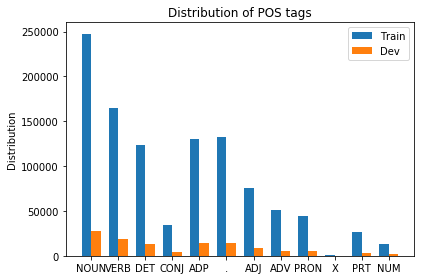

In [10]:
# Display the distribution of POS tags in the train and dev sets.
# This code is an adaptation of:
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

# built the list of tags (categories)
labels = list(train_pos_distribution.keys())

# built the lists of category distributions for the 2 datasets
train_probs = [train_pos_distribution[k] for k in labels]
test_probs = [test_pos_distribution[k] for k in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_probs, width, label='Train')
rects2 = ax.bar(x + width/2, test_probs, width, label='Dev')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distribution')
ax.set_title('Distribution of POS tags')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

We now look at word distribution.

In [11]:
# Input:
# - data: a dataset
# Output:
# a dictionnary where each key is a word and the associated value is the number of occurences of this word in the dataset
def compute_word_counts(data):
    distribution = {}
    for sentence in data:
        for word, tag in sentence:
            if word in distribution:
                distribution[word] += 1
            else:
                distribution[word] = 1
    return distribution

In [12]:
train_word_counts = compute_word_counts(train_data)
test_word_counts = compute_word_counts(test_data)

In [13]:
# Input:
# - data: a dataset
# - words: a set of words
# Output:
# the percentage of words in the dataset that are in the input set words
def compute_cover(dataset, words):
    good_words = sum(sum(1 for word, tag in sentence if word in words) for sentence in dataset)
    all_words = sum(len(sentence) for sentence in dataset)
    return good_words / all_words

We want to display a plot that shows the percentage of the train/test datasets that are covered with the N most frequent words.

In [14]:
x = list()
y_train = list()
y_dev = list()

from collections import Counter 
max_n_words = 100
train_frequent_words = [word for (word, c) in Counter(train_word_counts).most_common(max_n_words)]
test_frequent_words = [word for (word, c) in Counter(test_word_counts).most_common(max_n_words)]
for i in range(1, max_n_words):
    x.append(i)
    y_train.append(compute_cover(train_data, set(train_frequent_words[:i])))
    y_dev.append(compute_cover(test_data, set(test_frequent_words[:i])))

We now plot the data. What can you deduce from this plot?

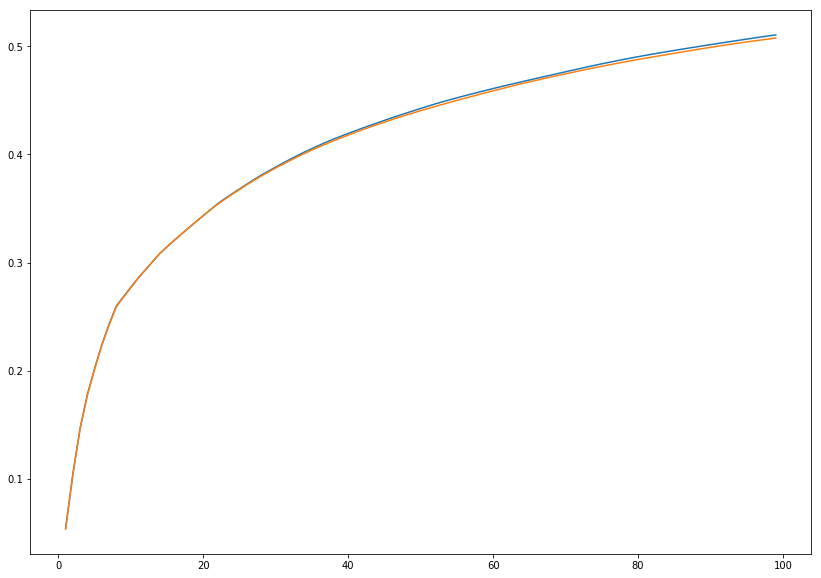

In [15]:
fig=plt.figure(figsize=(14, 10))
plt.plot(x, y_train)
plt.plot(x, y_dev)
plt.show()

# Training the tagger

We now train a really simple discriminative POS tagger. We will learn the distribution p(y | x) where y is a tag and x is a word.

Some words in the test data may not appear in the training data. In order to be robust to unknown words, we will learn the distribution p(y | x) for words that appear 10 or more times in the training data. Words that appears less than 10 times must be mapped to the "\*\*UNK\*\*" word. p(y | \*\*UNK\*\*) will be used to classify words that did not appear in the training data.

In [16]:
# pos_distribution_per_word should a dict of dicts:
# keys are words (including **UNK**) and values are dicts containing the POS tag distributions.
#
# p(y | x) is then pos_distribution_per_word[x][y]

pos_distribution_per_word = {}

# We start by counting the number of times a tag appears for each word
for sentence in train_data:
    for word, tag in sentence:
        if train_word_counts[word] < 10:
            word = "**UNK**"
        if word in pos_distribution_per_word:
            tag_dis = pos_distribution_per_word[word]
            if tag in tag_dis:
                tag_dis[tag] += 1
            else:
                tag_dis[tag] = 1
        else:
            pos_distribution_per_word[word] = {tag:1}
            
# Then we normalize each distribution by dividing by the number of times each word appears
for dis in pos_distribution_per_word.values():
    word_count = sum(c for c in dis.values())
    for tag in dis:
        dis[tag] /= word_count

pos_distribution_per_word

{'**UNK**': {'NOUN': 0.5876762330162041,
  'ADJ': 0.14294428429472358,
  'VERB': 0.19043496226916304,
  'X': 0.00897275705669956,
  'ADV': 0.03704213850709851,
  'PRT': 0.004801212109286607,
  'CONJ': 0.00011806259285131,
  'NUM': 0.024399602522604067,
  'PRON': 0.0010920789838746174,
  'DET': 0.0005312816678308951,
  'ADP': 0.0019480327820466151,
  '.': 3.9354197617103335e-05},
 'can': {'VERB': 0.9955835962145111,
  'NOUN': 0.0037854889589905363,
  'X': 0.0006309148264984228},
 'establish': {'VERB': 1.0},
 'a': {'DET': 0.9995937436522445,
  'NOUN': 5.078204346942921e-05,
  'X': 0.0003554743042860045},
 'unity': {'NOUN': 1.0},
 'and': {'CONJ': 0.9999203250736993, 'X': 7.967492630069317e-05},
 'of': {'ADP': 0.9999384653252108, 'X': 6.153467478924374e-05},
 'control': {'NOUN': 0.8695652173913043, 'VERB': 0.13043478260869565},
 ';': {'.': 1.0},
 'This': {'DET': 1.0},
 'third': {'ADJ': 0.9806451612903225,
  'ADV': 0.0064516129032258064,
  'NOUN': 0.012903225806451613},
 'choice': {'NOUN': 

What is percentage of words that have a single tag associated with it, i.e. words x such that there exists a tag for which p(y | x) = 1?

In [17]:
single_tag_count = sum(1 for word in pos_distribution_per_word if len(pos_distribution_per_word[word]) == 1)
single_tag_count / len(pos_distribution_per_word)

0.7572897761645493

What is percentage of words have a tag with a probability greater the 90%, i.e. words x such that there exists a tag for which p(y | x) > 0.9?

In [18]:
big_tag_count = sum(1 for word in pos_distribution_per_word if max(pos_distribution_per_word[word].values()) > 0.9)
big_tag_count / len(pos_distribution_per_word)

0.8661826981246219

# Evaluating the model

To evaluate the model, we perform maximum a posteriori classification on the test data:
1. for each word in the test data, predict the most probable tag under the p(y | x) distribution
2. the accuracy the the number of correctly predicted tags divided by the number of words in the test data

What is the accuracy of the model on test data?

How does it performs comparatively to a model that would have performed a priori classification? (you can look at the POS distribution plot above)

In [19]:
import operator
good_predictions = 0
n_predictions = 0
for sentence in test_data:
    for word, tag in sentence:
        if word not in train_word_counts or train_word_counts[word] < 10: 
            word = "**UNK**"
        predicted_tag = max(pos_distribution_per_word[word].items(), key=operator.itemgetter(1))[0]
        if predicted_tag == tag:
            good_predictions += 1
        n_predictions += 1
good_predictions / n_predictions

0.9170828310659549